# Vehicle Detection Project

## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

%matplotlib inline

## Feature extraction and classifier training

### Loading training data

In [2]:

VEHICLE_IMAGES = 'vehicles/vehicles/vehicles/**/*.png'
NON_VEHICLE_IMAGES = 'non-vehicles/non-vehicles/non-vehicles/**/*.png'

vehicles = glob.glob(VEHICLE_IMAGES)
non_vehicles = glob.glob(NON_VEHICLE_IMAGES)


#### Print out the number of samples in each category to avoid inbalanced representation:

In [3]:
print ("Vehicles samples: %d" % len(vehicles))
print ("Non-vehicles samples: %d" % len(non_vehicles))

Vehicles samples: 8792
Non-vehicles samples: 8968


#### Plot random samples for vehicles and non-vehicles:

Samples of vehicles


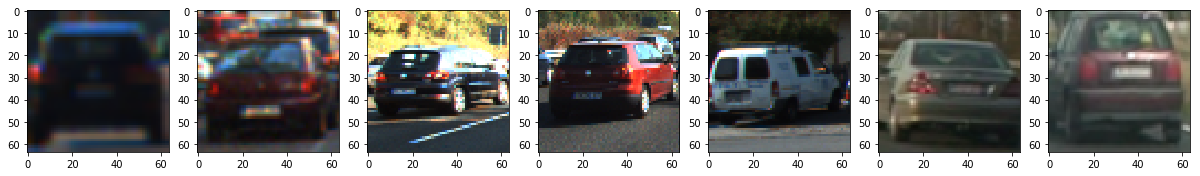

Samples of non-vehicles


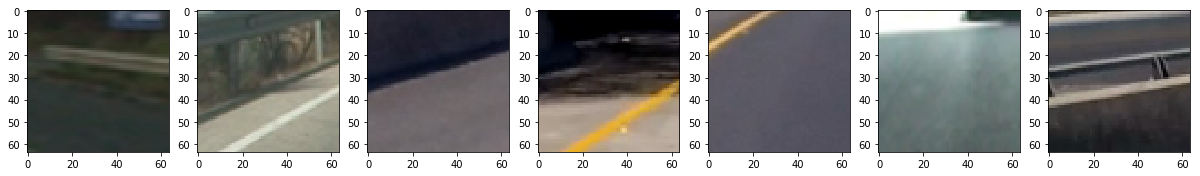

In [4]:
def plotRandomSamples(images, label, nr_samples):
    print ('Samples of %s' % label)
    selected_images = np.random.choice(images, nr_samples)
    fig = plt.figure(figsize = (30, 7))
    for (i, image) in enumerate(selected_images):
        axis = fig.add_subplot(1, 10, i + 1)
        img = cv2.imread(image)
        
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axis.imshow(img)
    plt.show()
    
nr_samples = 7
plotRandomSamples(vehicles, 'vehicles', nr_samples)
plotRandomSamples(non_vehicles, 'non-vehicles', nr_samples)

### Feature extraction

#### Set of utility functions mostly copied from the Udacity class materials

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with cv2!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(64, 64),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Samples of images with corresponding HOG features:

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


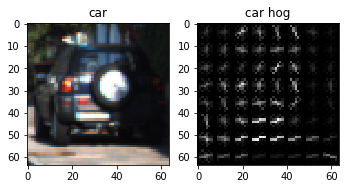

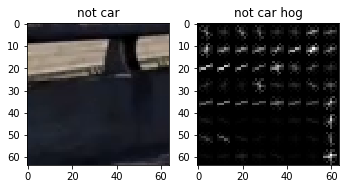

In [27]:
selected_car_image = np.random.choice(vehicles, 1)[0]
fig = plt.figure(figsize = (30, 10))
axis = fig.add_subplot(1, 10, 1)
car_img = cv2.cvtColor(cv2.imread(selected_car_image),cv2.COLOR_BGR2RGB)
_, car_hog = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
axis.set_title('car')
axis.imshow(car_img)
axis = fig.add_subplot(1, 10, 2)
axis.set_title('car hog')
axis.imshow(car_hog, cmap='gray')

selected_notcar_image = np.random.choice(non_vehicles, 1)[0]

fig = plt.figure(figsize = (30, 10))
axis = fig.add_subplot(1, 10, 1)
not_car_img = cv2.cvtColor(cv2.imread(selected_notcar_image),cv2.COLOR_BGR2RGB)
_, not_car_hog = get_hog_features(not_car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
axis.set_title('not car')
axis.imshow(non_car_img)
axis = fig.add_subplot(1, 10, 2)
axis.set_title('not car hog')
axis.imshow(not_car_hog, cmap='gray')



#### Definition of different feature extraction configurations:

In [6]:
#COLOR_SPACES = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
#COLOR_SPACES = ['LUV', 'HLS', 'YUV', 'YCrCb']
#COLOR_SPACES = ['HLS', 'YUV', 'YCrCb']
COLOR_SPACES = ['YUV', 'YCrCb']
#HOG_CHANNELS = ['ALL', 0, 1, 2, ]
HOG_CHANNELS = ['ALL'] #, 0, 1, 2, ]
ORIENTATIONS = [9, 11]
PIX_PER_CELL = [8]
CELL_PER_BLOCK = [2]
SPATIAL_FEATS = [False, True]
HIST_FEATS = [False] #, True]
HOG_FEATS = [False, True]

import itertools

def buildExtractionConfigurations():
    configurations = []
    for element in itertools.product(COLOR_SPACES, SPATIAL_FEATS, HIST_FEATS):
        configuration = {
            'color_space': element[0],
            'spatial_feat': element[1],
            'hist_feat': element[2]
        }

        for hog_feat in HOG_FEATS:
            hog_conf = configuration.copy()
            hog_conf['hog_feat'] = hog_feat
            if hog_feat is False:
                if ((hog_conf['spatial_feat'] is False)
                     and (hog_conf['hist_feat'] is False)):
                    continue
                hog_conf['hog_channel'] = None
                hog_conf['hog_orientations'] = None
                hog_conf['hog_pix_per_cell'] = None
                hog_conf['hog_cell_per_block'] = None
                configurations.append(hog_conf)
                continue
            for hog_params in itertools.product(HOG_CHANNELS, ORIENTATIONS, PIX_PER_CELL, CELL_PER_BLOCK):
                hog_params_conf = hog_conf.copy()
                hog_params_conf['hog_channel'] = hog_params[0]
                hog_params_conf['hog_orientations'] = hog_params[1]
                hog_params_conf['hog_pix_per_cell'] = hog_params[2]
                hog_params_conf['hog_cell_per_block'] = hog_params[3]                
                configurations.append(hog_params_conf)

    return configurations



#### Run classification training for each of the configurations

In [7]:
def trainClassifierForFeatureConfig(vehicles, non_vechicles, feature_config):
    vehicle_features = extract_features(
        vehicles,
        color_space=feature_config['color_space'],
        spatial_size=(64, 64),
        hist_bins=32,
        orient=feature_config['hog_orientations'], 
        pix_per_cell=feature_config['hog_pix_per_cell'],
        cell_per_block=feature_config['hog_cell_per_block'],
        hog_channel=feature_config['hog_channel'],
        spatial_feat=feature_config['spatial_feat'],
        hist_feat=feature_config['hist_feat'],
        hog_feat=feature_config['hog_feat'])
    non_vehicle_features = extract_features(
        non_vechicles,
        color_space=feature_config['color_space'],
        spatial_size=(64, 64),
        hist_bins=32,
        orient=feature_config['hog_orientations'], 
        pix_per_cell=feature_config['hog_pix_per_cell'],
        cell_per_block=feature_config['hog_cell_per_block'],
        hog_channel=feature_config['hog_channel'],
        spatial_feat=feature_config['spatial_feat'],
        hist_feat=feature_config['hist_feat'],
        hog_feat=feature_config['hog_feat'])

    # Stack features of both classes
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)  
    
    # Apply the scaler to X
    X_scaler = StandardScaler().fit(X)    
    X_scaled = X_scaler.transform(X)

    # Provide the labels vector
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=np.random.randint(0, 100))
    
    # Train the SVC
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    # Evaluate the accuracy on the test set
    accuracy = svc.score(X_test, y_test)

    print("Parameters: %s" % feature_config)
    print("Accuracy: %f" % accuracy)
    
    return (X_scaler, svc)

In [8]:
feature_configs = buildExtractionConfigurations();
print (len(feature_configs))
for feature_config in feature_configs:
    trainClassifierForFeatureConfig(vehicles, non_vehicles, feature_config)

10


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Parameters: {'hog_orientations': 9, 'color_space': 'YUV', 'hog_channel': 'ALL', 'hog_cell_per_block': 2, 'spatial_feat': False, 'hog_feat': True, 'hist_feat': False, 'hog_pix_per_cell': 8}
Accuracy: 0.982545
Parameters: {'hog_orientations': 11, 'color_space': 'YUV', 'hog_channel': 'ALL', 'hog_cell_per_block': 2, 'spatial_feat': False, 'hog_feat': True, 'hist_feat': False, 'hog_pix_per_cell': 8}
Accuracy: 0.984516
Parameters: {'hog_orientations': None, 'color_space': 'YUV', 'hog_channel': None, 'hog_cell_per_block': None, 'spatial_feat': True, 'hog_feat': False, 'hist_feat': False, 'hog_pix_per_cell': None}
Accuracy: 0.922860
Parameters: {'hog_orientations': 9, 'color_space': 'YUV', 'hog_channel': 'ALL', 'hog_cell_per_block': 2, 'spatial_feat': True, 'hog_feat': True, 'hist_feat': False, 'hog_pix_per_cell': 8}
Accuracy: 0.979730
Parameters: {'hog_orientations': 11, 'color_space': 'YUV', 'hog_channel': 'ALL', 'hog_cell_per_block': 2, 'spatial_feat': True, 'hog_feat': True, 'hist_feat': F

## Finding cars in images

### Utility functions (mostly copied from Udacity class materials)

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(64, 64), hist_bins=32, 
                    hist_range=(0, 1), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


### Train the classifer using chosen parameters

In [10]:
feature_config = {
    'color_space': 'YUV',
    'spatial_feat': False,
    'hog_feat': True,
    'hog_channel': 'ALL',
    'hog_orientations': 11,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 2,
    'hist_feat': False,
}

X_scaler, svc = trainClassifierForFeatureConfig(vehicles, non_vehicles, feature_config)


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Parameters: {'hist_feat': False, 'hog_feat': True, 'hog_pix_per_cell': 8, 'color_space': 'YUV', 'hog_channel': 'ALL', 'spatial_feat': False, 'hog_cell_per_block': 2, 'hog_orientations': 11}
Accuracy: 0.985642


### Define the function to identify vehicles in the image

In [11]:
def find_vehicles(img, clf, scaler, feature_config,
                  x_start_stop, y_start_stop, xy_window):
    windows = slide_window(
        img, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
        xy_window=xy_window, xy_overlap=(0.5, 0.5))
    hot_windows = search_windows(
        img, windows, clf, scaler,
        color_space=feature_config['color_space'],
        spatial_size=(64, 64),
        hist_bins=32,
        orient=feature_config['hog_orientations'], 
        pix_per_cell=feature_config['hog_pix_per_cell'],
        cell_per_block=feature_config['hog_cell_per_block'],
        hog_channel=feature_config['hog_channel'],
        spatial_feat=feature_config['spatial_feat'],
        hist_feat=feature_config['hist_feat'],
        hog_feat=feature_config['hog_feat'])
    return hot_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


### Test algorithm on test images:

./test_images/test3.jpg
[]


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


./test_images/test6.jpg
[((840, 400), (960, 520)), ((1020, 400), (1140, 520)), ((1080, 400), (1200, 520))]
./test_images/test5.jpg
[((840, 400), (960, 520)), ((1080, 400), (1200, 520)), ((1140, 400), (1260, 520))]
./test_images/test2.jpg
[]
./test_images/test4.jpg
[((840, 400), (960, 520)), ((1020, 400), (1140, 520)), ((1080, 400), (1200, 520)), ((1140, 400), (1260, 520))]
./test_images/test1.jpg
[((60, 400), (180, 520)), ((840, 400), (960, 520)), ((1080, 400), (1200, 520)), ((1140, 400), (1260, 520)), ((60, 460), (180, 580))]


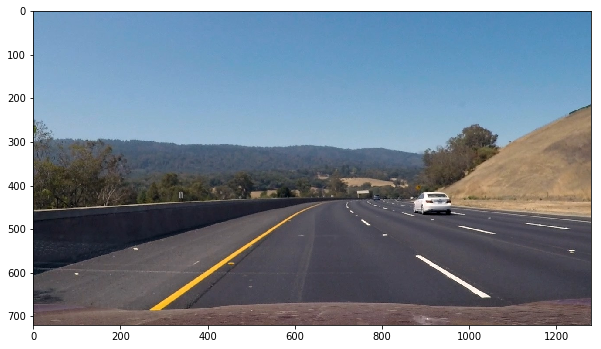

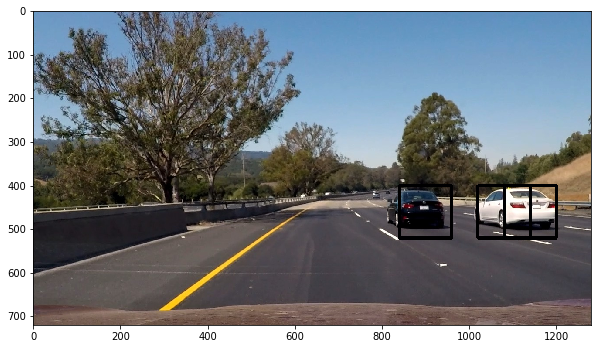

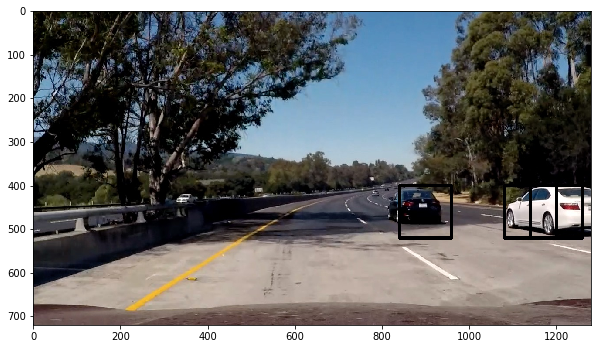

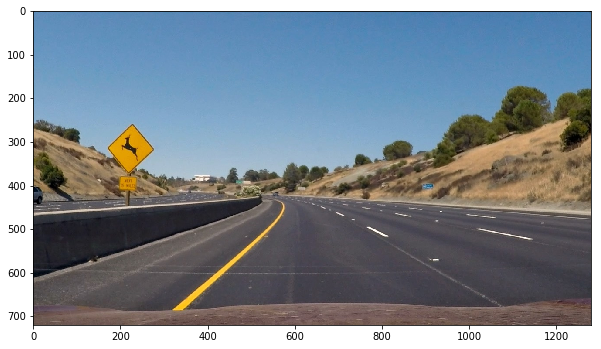

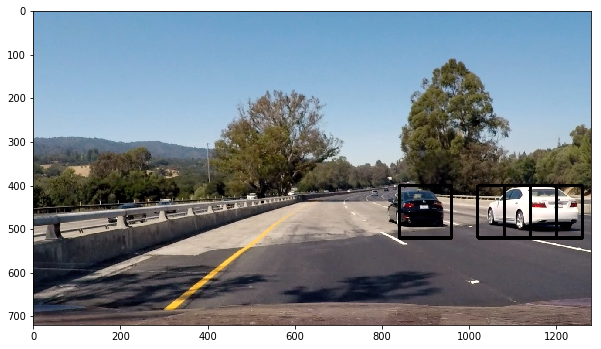

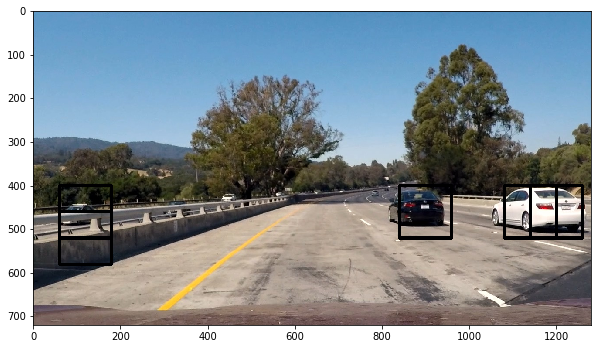

In [12]:
TEST_IMAGES = './test_images/*.jpg'
test_images = glob.glob(TEST_IMAGES)

y_start_stop = [400, 650]

for test_image in test_images:
    print (test_image)
    img = mpimg.imread(test_image)
    # We have read the jpg file using mpmimg. To be in sync with training
    # procedure we need to scale to [0 - 1]
    img = img.astype(np.float32)/255
    hot_windows = find_vehicles(
        img, svc, X_scaler, feature_config,
        x_start_stop=[None, None],
        y_start_stop = y_start_stop,
        xy_window = [120, 120])
    print (hot_windows)
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(10,10))
    plt.imshow(window_img)


In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,
              ystart, ystop, scale,
              svc, X_scaler,
              color_space,
              orient,
              pix_per_cell,
              cell_per_block,
              hog_channel,
              spatial_feat,
              hist_feat,
              hog_feat,
              spatial_size=(64, 64),
              hist_bins=32):
    hot_windows = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # Apply color conversion
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_feat == True:
        if hog_channel == 'ALL':            
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        elif hog_channel == 0:
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        elif hog_channel == 1:
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        elif hog_channel == 2:
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_features = []
            # Extract HOG for this patch            
            if hog_feat == True:
                if hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                elif hog_channel == 0:
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1))
                elif hog_channel == 1:
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat2))
                elif hog_channel == 2:
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = []
            hist_features = []
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)            
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return hot_windows
    

./test_images/test3.jpg
[((864, 380), (960, 476)), ((864, 404), (960, 500))]
./test_images/test6.jpg


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((792, 404), (888, 500)), ((816, 404), (912, 500)), ((840, 404), (936, 500)), ((864, 404), (960, 500)), ((984, 404), (1080, 500)), ((1008, 404), (1104, 500)), ((1032, 404), (1128, 500)), ((1056, 404), (1152, 500)), ((1056, 428), (1152, 524)), ((1080, 404), (1176, 500)), ((1080, 428), (1176, 524)), ((1104, 404), (1200, 500))]
./test_images/test5.jpg
[((0, 404), (96, 500)), ((24, 428), (120, 524)), ((120, 380), (216, 476)), ((480, 452), (576, 548)), ((480, 476), (576, 572)), ((816, 404), (912, 500)), ((840, 404), (936, 500)), ((840, 428), (936, 524)), ((864, 380), (960, 476)), ((864, 404), (960, 500)), ((912, 404), (1008, 500)), ((1008, 404), (1104, 500)), ((1080, 404), (1176, 500)), ((1104, 380), (1200, 476)), ((1104, 404), (1200, 500))]
./test_images/test2.jpg
[((912, 380), (1008, 476))]
./test_images/test4.jpg
[((120, 404), (216, 500)), ((216, 404), (312, 500)), ((792, 404), (888, 500)), ((816, 404), (912, 500)), ((840, 404), (936, 500)), ((864, 404), (960, 500)), ((1032, 404), (1128

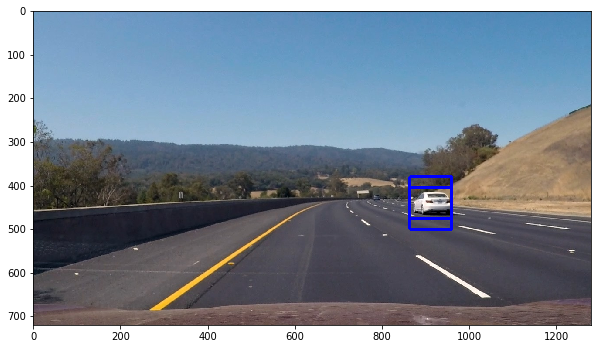

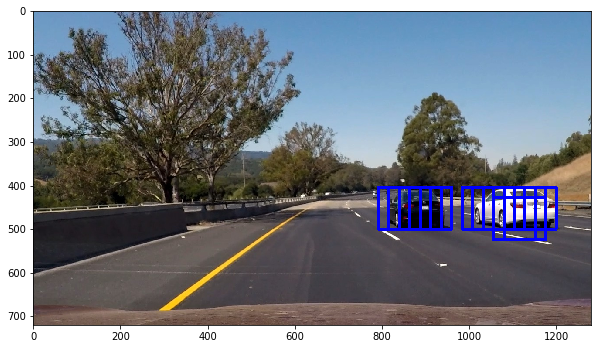

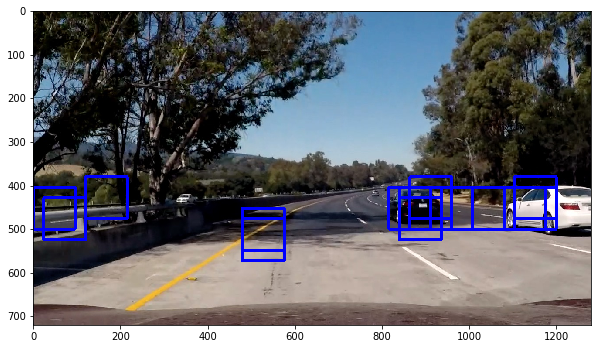

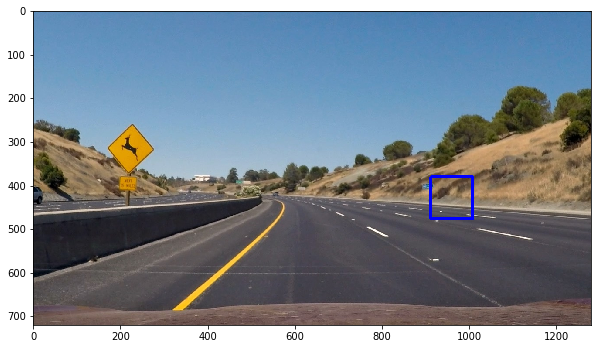

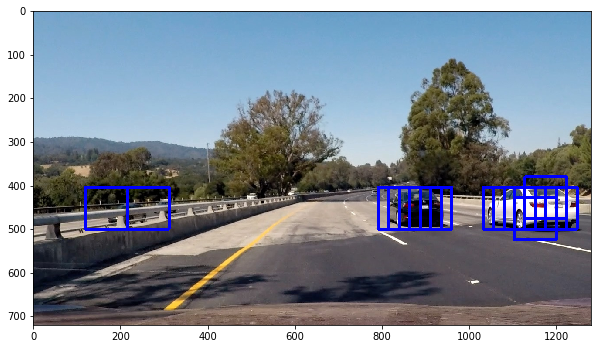

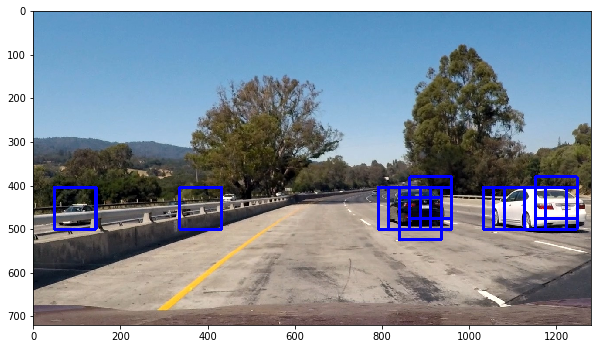

In [14]:
TEST_IMAGES = './test_images/*.jpg'
test_images = glob.glob(TEST_IMAGES)

y_start_stop = [380, 656]

for test_image in test_images:
    print (test_image)
    img = mpimg.imread(test_image)
    
    hot_windows = find_cars(
        img,
        y_start_stop[0], y_start_stop[1], 1.5,
        svc, X_scaler,              
        color_space=feature_config['color_space'],
        orient=feature_config['hog_orientations'], 
        pix_per_cell=feature_config['hog_pix_per_cell'],
        cell_per_block=feature_config['hog_cell_per_block'],
        hog_channel=feature_config['hog_channel'],
        spatial_feat=feature_config['spatial_feat'],
        hist_feat=feature_config['hist_feat'],
        hog_feat=feature_config['hog_feat'],
        spatial_size=(64, 64),
        hist_bins=32)

    print (hot_windows)
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(10,10))
    plt.imshow(window_img)


###  Combining multiple sliding windows to search for cars

./test_images/test3.jpg


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((864, 380), (960, 476)), ((864, 390), (960, 486)), ((864, 400), (960, 496))]
./test_images/test6.jpg
[((800, 380), (928, 508)), ((832, 380), (960, 508)), ((1024, 380), (1152, 508)), ((1056, 380), (1184, 508)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((816, 390), (912, 486)), ((816, 414), (912, 510)), ((840, 414), (936, 510)), ((1008, 414), (1104, 510)), ((1032, 390), (1128, 486)), ((1056, 414), (1152, 510)), ((1080, 390), (1176, 486)), ((1080, 414), (1176, 510)), ((1104, 414), (1200, 510)), ((1128, 414), (1224, 510)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496))]
./test_images/test5.jpg
[((800, 380), (928, 508)), ((832, 380), (960, 508)), ((864, 380), (992, 508)), ((1088, 380), (1216, 508)), ((800, 400), (928, 528)), ((83

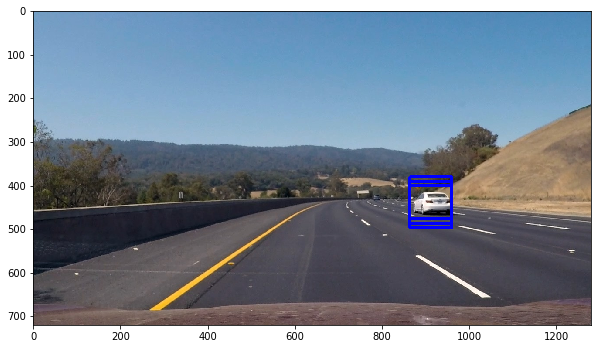

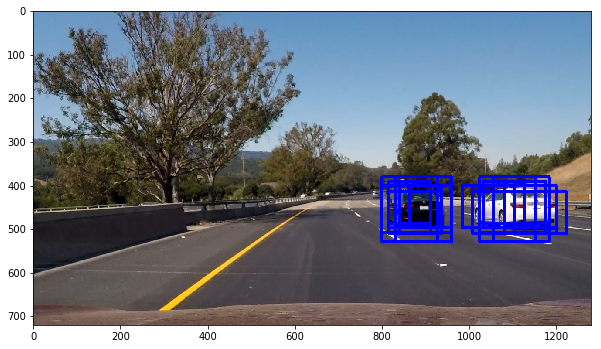

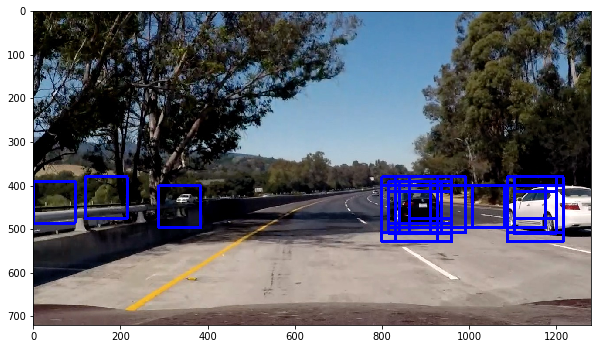

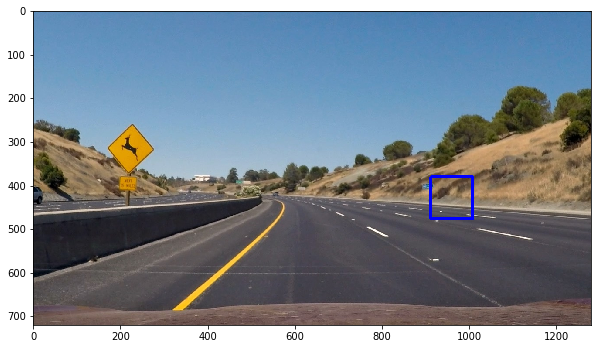

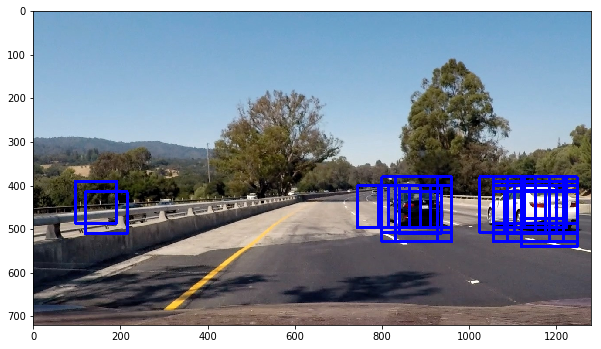

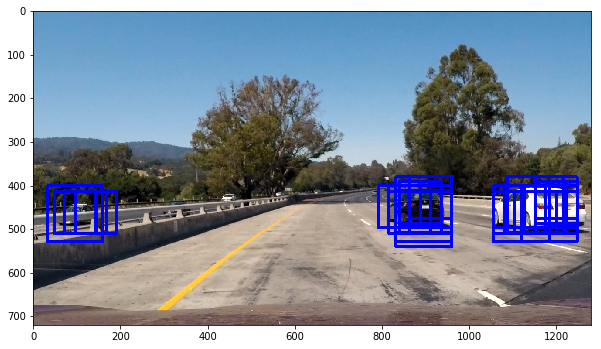

In [15]:
sliding_windows_configs = [
    (380, 650, 2.0),
    (400, 650, 2.0),
    (380, 500, 1.5),
    (390, 550, 1.5),
    (400, 520, 1.5),
    (380, 650, 3.5),
    (400, 650, 3.5),
]

for test_image in test_images:
    print (test_image)
    img = mpimg.imread(test_image)
    
    hot_windows = []
    for sliding_window in sliding_windows_configs:
        hot_windows.extend(find_cars(
            img,
            sliding_window[0], sliding_window[1], sliding_window[2],
            svc, X_scaler,              
            color_space=feature_config['color_space'],
            orient=feature_config['hog_orientations'], 
            pix_per_cell=feature_config['hog_pix_per_cell'],
            cell_per_block=feature_config['hog_cell_per_block'],
            hog_channel=feature_config['hog_channel'],
            spatial_feat=feature_config['spatial_feat'],
            hist_feat=feature_config['hist_feat'],
            hog_feat=feature_config['hog_feat'],
            spatial_size=(64, 64),
            hist_bins=32))

    print (hot_windows)
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(10,10))
    plt.imshow(window_img)


### Using heatmap to filter out results and draw single box

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


./test_images/test3.jpg


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((864, 380), (960, 476)), ((864, 390), (960, 486)), ((864, 400), (960, 496))]
1 cars found
./test_images/test6.jpg
[((800, 380), (928, 508)), ((832, 380), (960, 508)), ((1024, 380), (1152, 508)), ((1056, 380), (1184, 508)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((816, 390), (912, 486)), ((816, 414), (912, 510)), ((840, 414), (936, 510)), ((1008, 414), (1104, 510)), ((1032, 390), (1128, 486)), ((1056, 414), (1152, 510)), ((1080, 390), (1176, 486)), ((1080, 414), (1176, 510)), ((1104, 414), (1200, 510)), ((1128, 414), (1224, 510)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496))]
2 cars found
./test_images/test5.jpg
[((800, 380), (928, 508)), ((832, 380), (960, 508)), ((864, 380), (992, 508)), ((1088, 380), (1216, 508)), ((80

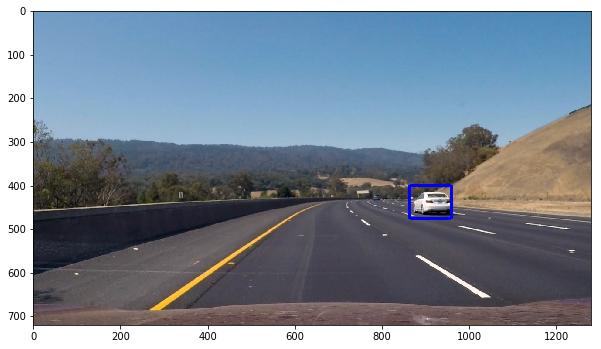

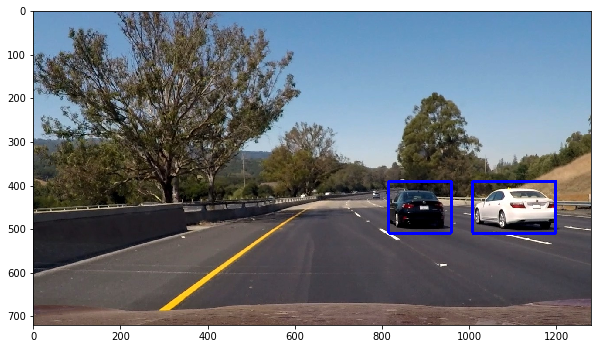

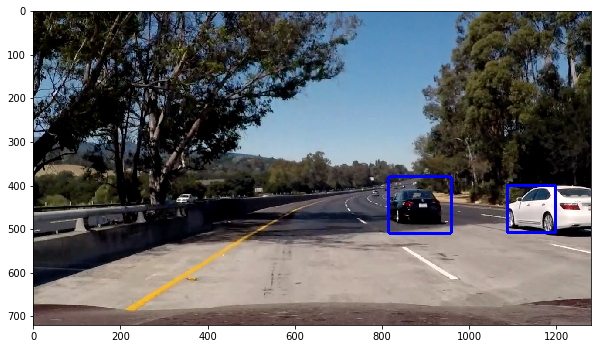

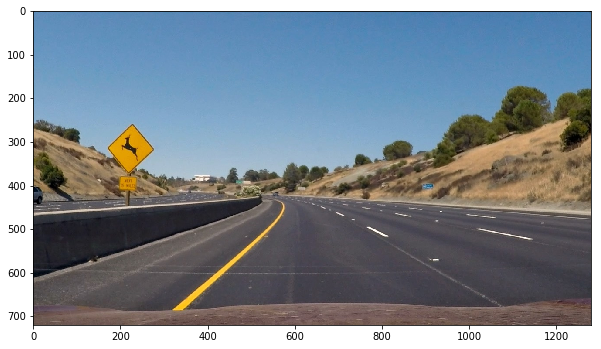

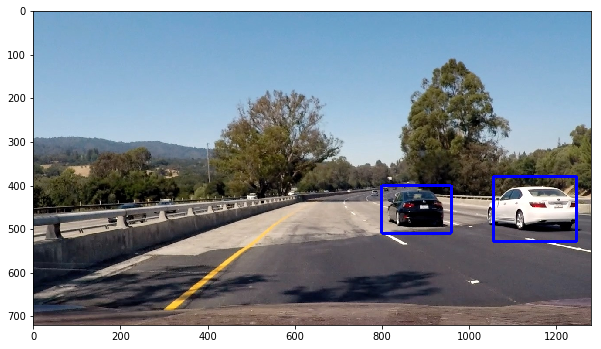

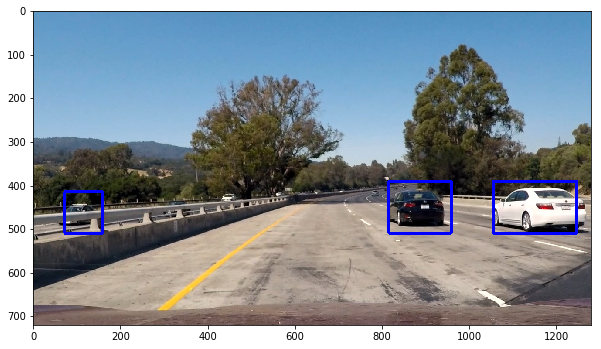

In [17]:
for test_image in test_images:
    print (test_image)
    img = mpimg.imread(test_image)
    
    hot_windows = []
    for sliding_window in sliding_windows_configs:
        hot_windows.extend(find_cars(
            img,
            sliding_window[0], sliding_window[1], sliding_window[2],
            svc, X_scaler,              
            color_space=feature_config['color_space'],
            orient=feature_config['hog_orientations'], 
            pix_per_cell=feature_config['hog_pix_per_cell'],
            cell_per_block=feature_config['hog_cell_per_block'],
            hog_channel=feature_config['hog_channel'],
            spatial_feat=feature_config['spatial_feat'],
            hist_feat=feature_config['hist_feat'],
            hog_feat=feature_config['hog_feat'],
            spatial_size=(64, 64),
            hist_bins=32))

    print (hot_windows)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, hot_windows)
    heatmap_img = apply_threshold(heatmap_img, 2)
    
    labels = label(heatmap_img)
    print(labels[1], 'cars found')
    
    window_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.figure(figsize=(10,10))
    plt.imshow(window_img)


## Processing video input

In [158]:
def process_frame(img):
    hot_windows = []
    for sliding_window in sliding_windows_configs:
        hot_windows.extend(find_cars(
            img,
            sliding_window[0], sliding_window[1], sliding_window[2],
            svc, X_scaler,              
            color_space=feature_config['color_space'],
            orient=feature_config['hog_orientations'], 
            pix_per_cell=feature_config['hog_pix_per_cell'],
            cell_per_block=feature_config['hog_cell_per_block'],
            hog_channel=feature_config['hog_channel'],
            spatial_feat=feature_config['spatial_feat'],
            hist_feat=feature_config['hist_feat'],
            hog_feat=feature_config['hog_feat'],
            spatial_size=(64, 64),
            hist_bins=32))

    #print (hot_windows)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, hot_windows)
    heatmap_img = apply_threshold(heatmap_img, 1)
    
    labels = label(heatmap_img)
    #print(labels[1], 'cars found')
    
    window_img = draw_labeled_bboxes(np.copy(img), labels)
    return window_img

In [159]:
from moviepy.editor import VideoFileClip

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [00:11<00:00,  3.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 11.7 s, sys: 92 ms, total: 11.8 s
Wall time: 12 s


In [132]:
project_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



100%|█████████▉| 1260/1261 [03:50<00:00,  5.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 57s, sys: 2.08 s, total: 3min 59s
Wall time: 3min 50s


### Collecting the history of previously identified cars:

In [33]:
class TrackRecords:
    def __init__(self, nr_frames):
        self.hot_windows = []
        self.nr_frames = nr_frames
        
    def add(self, hot_windows):
        self.hot_windows.append(hot_windows)
        if len(self.hot_windows) > self.nr_frames:
            self.hot_windows.pop(0)
    
    def get_hot_windows(self):
        return list(itertools.chain.from_iterable(self.hot_windows))

tracker = TrackRecords(15)    
    
def process_frame_with_history(img):
    hot_windows = []
    for sliding_window in sliding_windows_configs:
        hot_windows.extend(find_cars(
            img,
            sliding_window[0], sliding_window[1], sliding_window[2],
            svc, X_scaler,              
            color_space=feature_config['color_space'],
            orient=feature_config['hog_orientations'], 
            pix_per_cell=feature_config['hog_pix_per_cell'],
            cell_per_block=feature_config['hog_cell_per_block'],
            hog_channel=feature_config['hog_channel'],
            spatial_feat=feature_config['spatial_feat'],
            hist_feat=feature_config['hist_feat'],
            hog_feat=feature_config['hog_feat'],
            spatial_size=(64, 64),
            hist_bins=32))

    #print (hot_windows)
    tracker.add(hot_windows)
    hist_hot_windows = tracker.get_hot_windows()
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, hist_hot_windows)
    heatmap_img = apply_threshold(heatmap_img, 2 * (15//3))
    
    labels = label(heatmap_img)
    window_img = draw_labeled_bboxes(np.copy(img), labels)
    return window_img

In [34]:
from moviepy.editor import VideoFileClip

project_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame_with_history)
%time clip_test_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [06:13<00:00,  3.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 6min 20s, sys: 2.58 s, total: 6min 22s
Wall time: 6min 14s
